<a href="https://colab.research.google.com/github/workingbetter/ITNPBD5_Dissertation/blob/main/Impact_of_road_conditions_on_discharge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data cleaning and preparing for Machine learning

In [ ]:
# Importing Necessary Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Folder path for the dataset Trips, Can be sourced from University of Stirling Repository
folder_path = "/Measurement_Data/Trips" # Change this to file location
all_files = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')])

# Feature Engineering
def extract_features(file_path, trip_name):
    df = pd.read_csv(file_path, delimiter=';', encoding='latin-1')

    # List of necessary columns for the analysis
    necessary_columns = ['Time [s]', 'Velocity [km/h]', 'SoC [%]', 'Ambient Temperature [°C]']

    # Drop rows with NaN values only in the necessary columns
    df.dropna(subset=necessary_columns, inplace=True)

    # Reset index after dropping rows
    df.reset_index(drop=True, inplace=True)

    # If dataframe is empty after dropping NaN values, return None
    if df.empty:
        print(f"Skipped {trip_name} as it's empty after dropping NaN rows.")
        return None

    trip_time = df['Time [s]'].iloc[-1] / 60  # Convert from seconds to minutes
    avg_velocity = df['Velocity [km/h]'].mean()
    initial_soc = df['SoC [%]'].iloc[0]  # First entry
    final_soc = df['SoC [%]'].iloc[-1]  # Last entry
    avg_ambient_temp = df['Ambient Temperature [°C]'].mean()

    return pd.DataFrame({
        'Trip': [trip_name],
        'Trip Time [min]': [trip_time],  # Updated column name
        'Average Velocity [km/h]': [avg_velocity],
        'Initial SoC [%]': [initial_soc],
        'Final SoC [%]': [final_soc],
        'Average Ambient Temperature [°C]': [avg_ambient_temp]
    })


master_df = pd.DataFrame()  # Empty dataframe to store all the extracted features

# Iterating through each file
for file in all_files:
    trip_name = os.path.basename(file).replace('.csv', '')  # Extracting the file name without extension
    trip_features = extract_features(file, trip_name)
    master_df = pd.concat([master_df, trip_features], ignore_index=True)

# Calculate distance (Km) for each trip
master_df['Distance (Km)'] = (master_df['Trip Time [min]'] / 60) * master_df['Average Velocity [km/h]']

# Calculate discharge rate (%/km) for each trip
master_df['Discharge Rate (%/km)'] = (master_df['Final SoC [%]'] - master_df['Initial SoC [%]']) / master_df['Distance (Km)']

# Calculate the delta_SoC
master_df['delta_SoC'] = master_df['Final SoC [%]'] - master_df['Initial SoC [%]']


In [ ]:
display(master_df)

,Trip,Trip Time [min],Average Velocity [km/h],Initial SoC [%],Final SoC [%],Average Ambient Temperature [°C],Distance (Km),Discharge Rate (%/km),delta_SoC
0,TripA01,16.815000,26.502170,86.9,81.5,30.769972,7.427233,-0.727054,-5.4
1,TripA02,23.548333,59.909267,80.3,67.3,31.127573,23.512723,-0.552892,-13.0
2,TripA03,11.175000,68.826493,83.5,75.1,23.334916,12.818934,-0.655281,-8.4
3,TripA04,6.871667,93.645415,75.1,66.7,24.423957,10.725001,-0.783217,-8.4
4,TripA05,22.776667,32.646337,66.7,60.2,24.587443,12.392912,-0.524493,-6.5
...,...,...,...,...,...,...,...,...,...
63,TripB32,13.258333,64.438389,52.6,38.1,2.193433,14.239094,-1.018323,-14.5
64,TripB33,9.131667,46.205445,77.4,71.6,4.194641,7.032212,-0.824776,-5.8
65,TripB35,22.706667,40.740879,85.4,71.5,7.618703,15.418159,-0.901534,-13.9
66,TripB36,47.533333,48.871933,72.1,44.5,7.201695,38.717431,-0.712857,-27.6


In [ ]:
# master_df.to_csv("Folder path") # change Folder path for saving

# Creating Machine learning model

In [ ]:
# Extracting features and target
X = master_df[['Trip Time [min]', 'Average Velocity [km/h]', 'Initial SoC [%]', 'Average Ambient Temperature [°C]', 'Distance (Km)']]
y = master_df['delta_SoC']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3071806)

# Keep a copy of the original X_test for 'Initial SoC [%]'
X_test_original = X_test.copy()

# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=1000, batch_size=10, validation_split=0.2)

# Predicting on the test set
y_pred_delta = model.predict(X_test).flatten()

# Adjust the predictions to get final SoC
y_pred_final = y_pred_delta + X_test_original['Initial SoC [%]'].values


Epoch 1/1000
5/5 [==============================] - 1s 53ms/step - loss: 376.9009 - val_loss: 171.6505
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 373.8814 - val_loss: 168.4917
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 377.5594 - val_loss: 165.3679
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 356.3031 - val_loss: 162.1020
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 356.6293 - val_loss: 158.8313
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 343.1773 - val_loss: 155.4917
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 335.3519 - val_loss: 151.9777
Epoch 8/1000
5/5 [==============================] - 0s 17ms/step - loss: 341.6821 - val_loss: 148.5291
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - loss: 340.9605 - val_loss: 144.9296
Epoch 10/1000
5/5 [==============================] - 0s 15ms/step - loss: 3

## Checking how well the model predicts

In [ ]:
# Predicting using new input data
trip_time = 23.55 # Trip time in Minutes
avg_velocity = 59.9 # Average velocity in KM/hr
initial_soc = 80.3 # Start charge
avg_ambient_temp = 31.12 # Outside temperature throughout the trip

distance = (trip_time / 60) * avg_velocity # Calcualted distance from speed and time

# Transforming Input data for ML
input_data = pd.DataFrame({
    'Trip Time [min]': [trip_time],
    'Average Velocity [km/h]': [avg_velocity],
    'Initial SoC [%]': [initial_soc],
    'Average Ambient Temperature [°C]': [avg_ambient_temp],
    'Distance (Km)': [distance]
})

# Scale the input data
input_data = scaler.transform(input_data)

# Predict delta_SoC using the trained neural network
predicted_delta_soc = model.predict(input_data).flatten()[0]

# Adjust the prediction to get final SoC
predicted_final_soc = predicted_delta_soc + initial_soc
print(f"Predicted Final SoC [%]: {predicted_final_soc:.2f}")

1/1 [==============================] - 0s 33ms/step
Predicted Final SoC [%]: 67.18


# How Temperature and Speed affects the final State of Charge

In [ ]:
# Temperature range
temperatures = np.linspace(-6, 40, 100)

# Predict Final SoC for each temperature
predicted_final_socs_temp = []
for temp in temperatures:
    input_data = pd.DataFrame({
        'Trip Time [min]': [trip_time],
        'Average Velocity [km/h]': [avg_velocity],
        'Initial SoC [%]': [initial_soc],
        'Average Ambient Temperature [°C]': [temp],
        'Distance (Km)': [distance]
    })

    input_data = scaler.transform(input_data)
    predicted_delta_soc = model.predict(input_data).flatten()[0]
    predicted_final_soc = predicted_delta_soc + initial_soc
    predicted_final_socs_temp.append(predicted_final_soc)

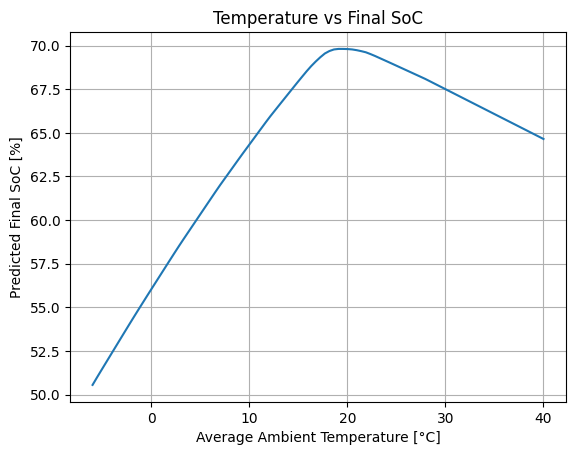

In [ ]:
# Plotting
plt.plot(temperatures, predicted_final_socs_temp)
plt.xlabel('Average Ambient Temperature [°C]')
plt.ylabel('Predicted Final SoC [%]')
plt.title('Temperature vs Final SoC')
plt.grid(True)
plt.show()

In [ ]:
# Speed range
speeds = np.linspace(20, 120, 100)

# Fixed distance
fixed_distance = 23.51

# Predict Final SoC for each speed
predicted_final_socs_speed = []
for speed in speeds:
    trip_time_speed = (fixed_distance / speed) * 60  # Convert to minutes

    input_data = pd.DataFrame({
        'Trip Time [min]': [trip_time_speed],
        'Average Velocity [km/h]': [speed],
        'Initial SoC [%]': [initial_soc],
        'Average Ambient Temperature [°C]': [avg_ambient_temp],
        'Distance (Km)': [fixed_distance]
    })

    input_data = scaler.transform(input_data)
    predicted_delta_soc = model.predict(input_data).flatten()[0]
    predicted_final_soc = predicted_delta_soc + initial_soc
    predicted_final_socs_speed.append(predicted_final_soc)

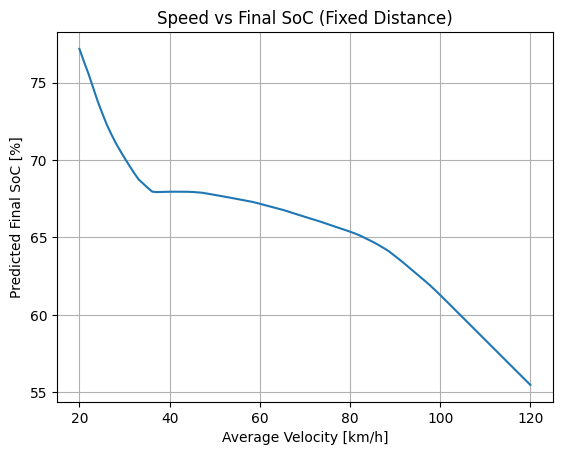

In [ ]:
# Plotting
plt.plot(speeds, predicted_final_socs_speed)
plt.xlabel('Average Velocity [km/h]')
plt.ylabel('Predicted Final SoC [%]')
plt.title('Speed vs Final SoC (Fixed Distance)')
plt.grid(True)
plt.show()